In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import multiprocessing


# Computer characteristics
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes / (1024.**3)
print("Computer characteristics: ")
print("RAM: %f GB" % mem_gib)
print("CORES: %d" % multiprocessing.cpu_count())


Computer characteristics: 
RAM: 7.653069 GB
CORES: 4


In [27]:
dataframe = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Check null values
print("Null values:\n", dataframe.isnull().sum())
print("\n")
countries = dataframe['Country_Region'].unique()
print("Number of different countries: ", len(countries))
print("\n")
min_date = dataframe.Date.min()
max_date = dataframe.Date.max()
print("Min date: {0}\nMax date: {1}".format(min_date, max_date))

Null values:
 Id                    0
Province_State    12848
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64


Number of different countries:  180


Min date: 2020-01-22
Max date: 2020-04-03


In [28]:
# where Province_State is null we fill it with Country_Region
def fillState(state, country):
    if state == "empty":
        return country
    return state

dataframe['Province_State'].fillna("empty", inplace = True)
dataframe['Province_State'] = dataframe.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)

test['Province_State'].fillna("empty", inplace = True)
test['Province_State'] = test.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)

dataframe.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


In [29]:
latest = dataframe['Date'].max()
world_confirmed = sum(dataframe[dataframe['Date'] == latest].ConfirmedCases)
print("Number of confirmed cases: ", world_confirmed)
world_fatal = sum(dataframe[dataframe['Date'] == latest].Fatalities)
print("Number of fatal cases: ", world_fatal)

Number of confirmed cases:  1095739.0
Number of fatal cases:  58782.0


In [30]:
latest_data = dataframe[dataframe['Date'] == latest]
latest_data = latest_data.drop(['Province_State'], axis = 1)

confirmed_per_country = latest_data.groupby(['Country_Region']).sum().sort_values(['ConfirmedCases'], ascending = False)
confirmed_per_country = confirmed_per_country.drop(['Id'], axis = 1)
print("First 10 countries by number of confirmed cases:\n")
print(confirmed_per_country[:10])
print("\n")
Serbia = confirmed_per_country.loc["Serbia"]
print("Confirmed cases in Serbia: ", Serbia.ConfirmedCases)
print("Fatal cases in Serbia: ", Serbia.Fatalities)

First 10 countries by number of confirmed cases:

                ConfirmedCases  Fatalities
Country_Region                            
US                    275426.0      7083.0
Italy                 119827.0     14681.0
Spain                 119199.0     11198.0
Germany                91159.0      1275.0
China                  82511.0      3326.0
France                 65202.0      6520.0
Iran                   53183.0      3294.0
United Kingdom         38689.0      3611.0
Turkey                 20921.0       425.0
Switzerland            19606.0       591.0


Confirmed cases in Serbia:  1476.0
Fatal cases in Serbia:  39.0


In [31]:
fig = go.Figure()
date = dataframe['Date'].unique()
Serbia_confirmed = dataframe[dataframe['Country_Region'] == 'Serbia'].groupby(['Date']).sum().ConfirmedCases
Serbia_confirmed
Serbia_fatalities = dataframe[dataframe['Country_Region'] == 'Serbia'].groupby(['Date']).sum().Fatalities
fig.add_trace(go.Scatter(x = date, y = Serbia_confirmed, name = "Confirmed cases"))
fig.add_trace(go.Scatter(x = date, y = Serbia_fatalities, name = "Fatal cases"))
fig.update_layout(title = "COVID-19 cases in Serbia",
                 xaxis_title = "Date",
                 yaxis_title = "Cases")


##  Global forecast

In [32]:
confirmed = dataframe.groupby(['Date']).agg({'ConfirmedCases': ['sum']})
fatalities = dataframe.groupby(['Date']).agg({'Fatalities':['sum']})

print(confirmed.head())
print(fatalities.head())

           ConfirmedCases
                      sum
Date                     
2020-01-22          554.0
2020-01-23          653.0
2020-01-24          939.0
2020-01-25         1432.0
2020-01-26         2113.0
           Fatalities
                  sum
Date                 
2020-01-22       17.0
2020-01-23       18.0
2020-01-24       26.0
2020-01-25       42.0
2020-01-26       56.0


### Forecasting number of confirmed cases globally

In [33]:
np.random.seed(7)

dataset = confirmed.values
dataset = dataset.astype('float32')

# LSTMs are sensitive to the scale of the input data, specifically 
# when sigmoid or tanh activation functions are used.
# It's good to rescale the data to the range of [0,1] (to normalize)
# we use MinMaxScaler to do that

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# we need to estimate the skill of the model on new unseen data
# we can split the ordered dataset into train and test datasets
# 80% of the observations to train our model
# 20% for testing the model

train_size = int(len(dataset)*0.80)
test_size = len(dataset) - train_size
print(len(dataset))

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# convert an array of values into a dataset matrix
# first column is X at timestep t and second is y at timestep t+1
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1

trainX, trainY = create_dataset(train, look_back)
# we take testX and put it in our model and we get some values
# then we compare the values with existing values of testY
testX, testY = create_dataset(test, look_back)


# the LSTM network expects the input data (X) to be provided with a 
# specific array structure in from of: [samples, time steps, features]
# currently, our data is in the form: [samples, features] and we are
# framing the problem as one time step for each sample
# we can transform the prepared train and test input data into the expected 
# structure using numpy.reshape()

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

73
58 15


In [34]:
# one layer input
# hidden later with 4 LSTM neurons
# output layer makes a single value prediction
# sigmoid activation function (default)
# the network is trained for 100 epochs
# batch size of 1 is used


model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
 - 1s - loss: 0.0031
Epoch 2/100
 - 0s - loss: 0.0020
Epoch 3/100
 - 0s - loss: 0.0019
Epoch 4/100
 - 0s - loss: 0.0018
Epoch 5/100
 - 0s - loss: 0.0017
Epoch 6/100
 - 0s - loss: 0.0017
Epoch 7/100
 - 0s - loss: 0.0016
Epoch 8/100
 - 0s - loss: 0.0015
Epoch 9/100
 - 0s - loss: 0.0014
Epoch 10/100
 - 0s - loss: 0.0013
Epoch 11/100
 - 0s - loss: 0.0011
Epoch 12/100
 - 0s - loss: 0.0010
Epoch 13/100
 - 0s - loss: 9.0878e-04
Epoch 14/100
 - 0s - loss: 8.1400e-04
Epoch 15/100
 - 0s - loss: 7.0830e-04
Epoch 16/100
 - 0s - loss: 5.7073e-04
Epoch 17/100
 - 0s - loss: 4.8140e-04
Epoch 18/100
 - 0s - loss: 3.9639e-04
Epoch 19/100
 - 0s - loss: 3.2086e-04
Epoch 20/100
 - 0s - loss: 2.4898e-04
Epoch 21/100
 - 0s - loss: 1.8585e-04
Epoch 22/100
 - 0s - loss: 1.4321e-04
Epoch 23/100
 - 0s - loss: 1.0279e-04
Epoch 24/100
 - 0s - loss: 7.0450e-05
Epoch 25/100
 - 0s - loss: 5.3504e-05
Epoch 26/100
 - 0s - loss: 3.8201e-05
Epoch 27/100
 - 0s - loss: 2.6793e-05
Epoch 28/100
 - 0s - loss: 1.84

In [35]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#invert predictions to the same units as the original data
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
print("Real values: ")
print(testY)
print("Predicted values: ")
print(testPredict)
print("Number of confirmed cases for tomorrow:", testPredict[-1])

# calculate root mean squared error
# between our predicted values(trainPredict) and given values (trainY)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %2f RMSE' %(trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Test score: %2f RMSE" % (testScore))

Real values: 
[[ 304310.98666773  337326.99250517  377960.98697041  417950.9801948
   467563.00016914  529500.99696169  593201.01326603  660541.00252571
   719951.98557997  782199.9555003   857319.98630759  932434.01152833
  1012981.00368164]]
Predicted values: 
[[ 297762.5 ]
 [ 335941.16]
 [ 375054.06]
 [ 423234.78]
 [ 470501.97]
 [ 528651.06]
 [ 600033.1 ]
 [ 671537.56]
 [ 744553.1 ]
 [ 806491.8 ]
 [ 868714.06]
 [ 940028.  ]
 [1007171.7 ]]
Number of confirmed cases for tomorrow: [1007171.7]
Train Score: 3546.878736 RMSE
Test score: 11349.978499 RMSE


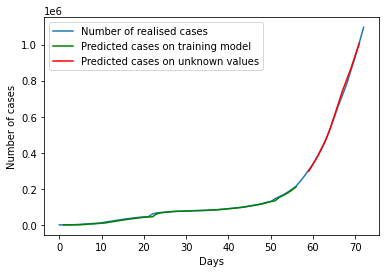

In [36]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color = 'green')
plt.plot(testPredictPlot, color = 'red')
plt.legend(['Number of realised cases', 'Predicted cases on training model', 'Predicted cases on unknown values'])
plt.xlabel("Days")
plt.ylabel("Number of cases")
plt.show()

### Forecasting number of fatal cases globally
